# ASHRAE - Great Energy Predictor III

### General Project / Past Competition Information
Aim: Predicting energy consumption in commercial buildings.
Dataset: over 1,000 buildings daat oer 3-years period.


### Issues & Questions
- Data size is big, not easy to process each time.

## 1. Libraries & Data Set-up

In [36]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/test.csv')
train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/train.csv')
building_metadata = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/building_metadata.csv')
weather_train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_train.csv')
weather_test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_test.csv')

In [39]:
print("-----------\nTrain Data:")
display(train.head())
print(train.info())
print("-----------\nBuilding Metadata:")
display(building_metadata.head())
print(building_metadata.info())
print("-----------\nWeather Train Data:")
display(weather_train.head())
print(weather_train.info())

-----------
Train Data:


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None
-----------
Building Metadata:


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.1+ KB
None
-----------
Weather Train Data:


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None


### Merging train + building_metadata + weather_train -> 'train_merged'

In [40]:
train_merged = pd.merge(train, building_metadata, on='building_id', how='left')
train_merged = pd.merge(train_merged, weather_train, on=['site_id', 'timestamp'], how='left')

display(train_merged.head()) # train + building_metadata + weather_train 

missing_values = train_merged.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


Missing values in each column:
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64


## 2. Exploratory Data Analysis (EDA)

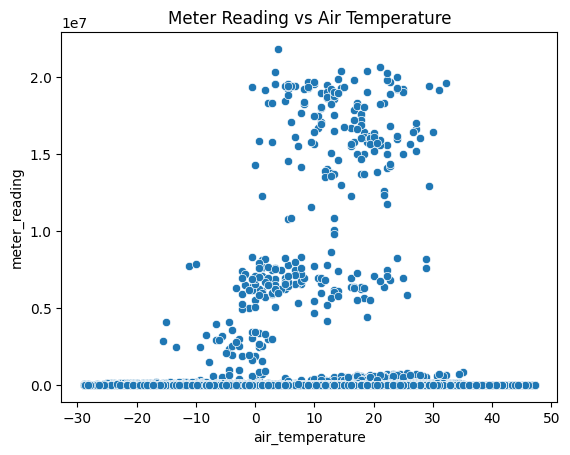

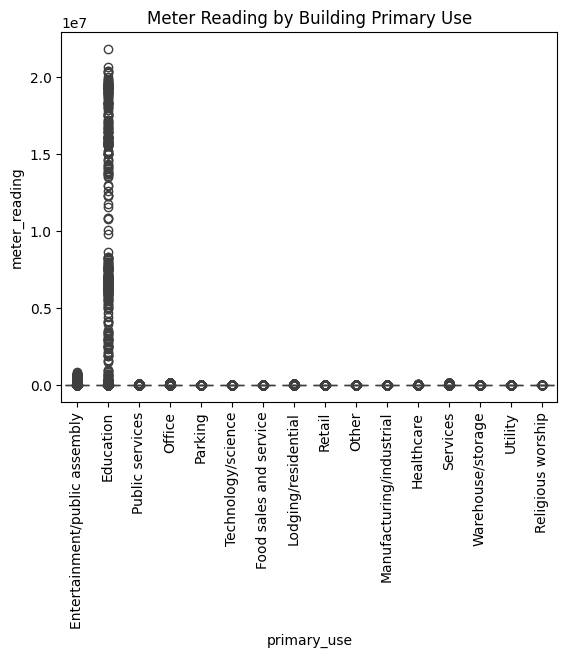

In [41]:
# Scatterplot: Meter reading vs Air Temperature
sns.scatterplot(x='air_temperature', y='meter_reading', data=sample_data)
plt.title('Meter Reading vs Air Temperature')
plt.show()

# Boxplot: Meter reading by Building Primary Use
sns.boxplot(x='primary_use', y='meter_reading', data=sample_data)
plt.xticks(rotation=90)
plt.title('Meter Reading by Building Primary Use')
plt.show()

Meter Reading Statistics:


count    2.021610e+06
mean     2.235222e+03
std      1.597998e+05
min      0.000000e+00
25%      1.826000e+01
50%      7.885000e+01
75%      2.684000e+02
max      2.184790e+07
Name: meter_reading, dtype: float64

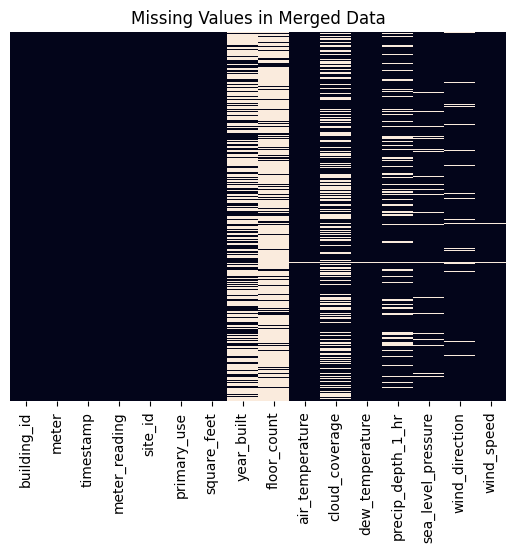

In [42]:
print("Meter Reading Statistics:")
display(sample_data['meter_reading'].describe())

# distribution
sns.heatmap(sample_data.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in Merged Data")
plt.show()

## Init Preprocessing

In [43]:
train_merged['air_temperature'].fillna(train_merged['air_temperature'].median(), inplace=True)

# add meaningful feautures
train_merged['hour'] = pd.to_datetime(train_merged['timestamp']).dt.hour
train_merged['day_of_week'] = pd.to_datetime(train_merged['timestamp']).dt.dayofweek

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_2709/669566197.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_merged['air_temperature'].fillna(train_merged['air_temperature'].median(), inplace=True)


### Sampling (For faster processing)

In [44]:
sample_data = train_merged.sample(frac=0.1, random_state=42)
display(sample_data.head())
sample_data.info()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day_of_week
14245562,1324,1,2016-09-16 16:00:00,0.0000,14,Entertainment/public assembly,84688,NaN,NaN,21.1,NaN,10.0,0.0,1026.1,170.0,1.5,16,4
1282718,1013,0,2016-01-24 06:00:00,32.0001,10,Education,67377,NaN,3.0,0.6,NaN,0.0,3.0,1012.4,160.0,4.1,6,6
13883790,229,1,2016-09-10 07:00:00,567.6550,2,Education,140092,NaN,NaN,33.3,4.0,13.3,0.0,1009.6,320.0,2.6,7,5
4781820,217,3,2016-04-01 01:00:00,0.0000,2,Education,282946,2003.0,NaN,21.7,NaN,-5.6,0.0,1009.3,240.0,5.7,1,4
10415393,1434,0,2016-07-10 04:00:00,65.7500,15,Education,33148,1967.0,NaN,19.4,NaN,14.4,NaN,1010.1,240.0,2.1,4,6


<class 'pandas.core.frame.DataFrame'>
Index: 2021610 entries, 14245562 to 466022
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
 16  hour                int32  
 17  day_of_week         int32  
dtypes: float64(10), int32(2), int64(4), object(2)
memory usage: 277.6+ MB
